Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [63]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [85]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("CNN_assignment/Train")
data_dir_test = pathlib.Path('CNN_assignment/Test')

In [84]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## training dataset
## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    label_mode='categorical'
)
print(train_ds)

num_samples = tf.data.experimental.cardinality(train_ds).numpy()
print("Number of samples in the dataset:", num_samples)

for images, labels in train_ds:
    print("Batch shape:", images.shape)
    break

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
Number of samples in the dataset: 56
Batch shape: (32, 180, 180, 3)


In [7]:
## Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    label_mode='categorical'
)
print(val_ds)

num_samples = tf.data.experimental.cardinality(val_ds).numpy()
print("Number of samples in the dataset:", num_samples)

for images, labels in val_ds:
    print("Batch shape:", images.shape)
    break

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
Number of samples in the dataset: 14
Batch shape: (32, 180, 180, 3)


In [86]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

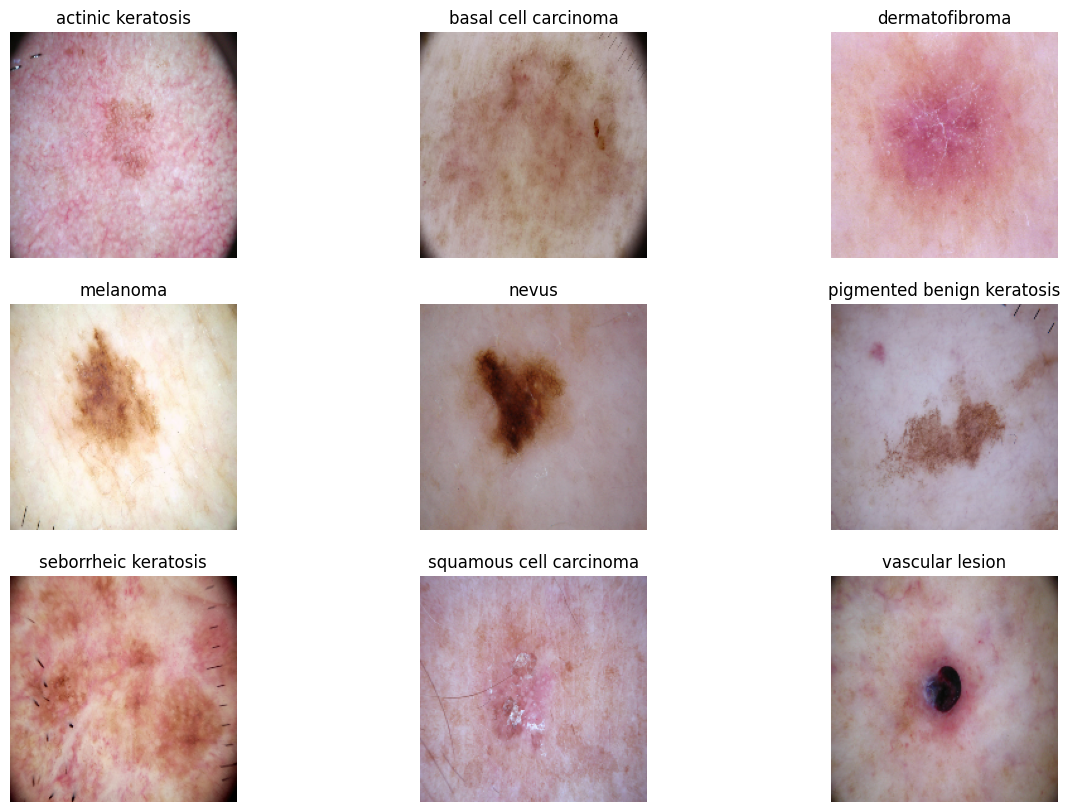

In [9]:
import matplotlib.pyplot as plt

# Create a dictionary to store one image from each class
one_instance_per_class = {class_name: None for class_name in class_names}

# Iterate through the dataset to find one instance from each class
for images, labels in val_ds:
    for image, label in zip(images, labels):
        class_name = class_names[tf.argmax(label).numpy()]
        if one_instance_per_class[class_name] is None:
            one_instance_per_class[class_name] = image.numpy()
    
    # Check if we have found one instance from each class
    if all(image is not None for image in one_instance_per_class.values()):
        break

# Visualize one instance from each class
plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(one_instance_per_class.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
#Define the CNN model
model = Sequential([
    # Normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))
])

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

C:\python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [87]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,659,113 (231.40 MB)

 Trainable params: 60,658,921 (231.40 MB)

 Non-trainable params: 192 (768.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2726 - loss: 2.2678 - val_accuracy: 0.0559 - val_loss: 2.2031
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5021 - loss: 1.4559 - val_accuracy: 0.0649 - val_loss: 2.2039
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5743 - loss: 1.2280 - val_accuracy: 0.0805 - val_loss: 2.2082
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6458 - loss: 1.0532 - val_accuracy: 0.1387 - val_loss: 2.2152
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.6899 - loss: 0.8964 - val_accuracy: 0.1723 - val_loss: 2.1943
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7459 - loss: 0.8192 - val_accuracy: 0.1857 - val_loss: 2.1537
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7830 - loss: 0.7197 - val_accuracy: 0.2483 - val_loss: 2.0567
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8066 - loss: 0.6535 - val_accuracy: 0.3154 - v

### Visualizing training results

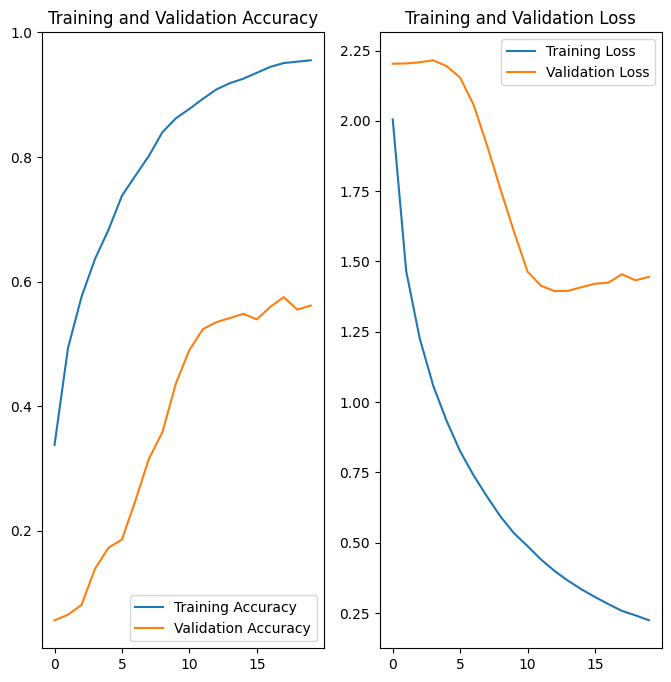

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- We see that training accuracy is much higher that validation accuracy. Tsis indicates that the model is clearly oerfitting.
- The accuracy is just around 50-60%, because the neural network is very young (just 20 epochs) and the learning has just started.

In [88]:
# choosing an appropriate data augumentation strategy. 
data_aug = keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

C:\python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


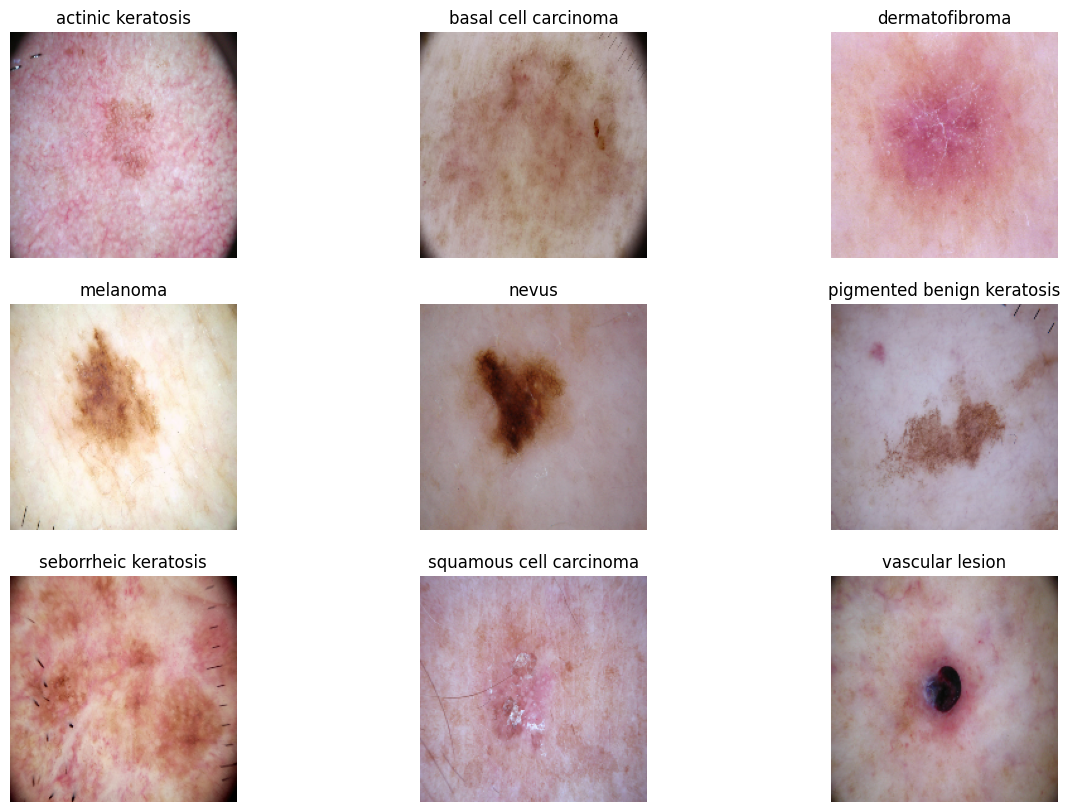

In [89]:
# visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(one_instance_per_class.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()

### Create the model, compile and train the model


In [94]:
## using Dropout layer as there is an evidence of overfitting in  findings

## Using a dropout layer and removing BN
model = Sequential([ data_aug,
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(9, activation = "softmax"))



### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 541ms/step - accuracy: 0.2159 - loss: 2.0776 - val_accuracy: 0.3512 - val_loss: 1.8491
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.2996 - loss: 1.8640 - val_accuracy: 0.3289 - val_loss: 1.8746
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.3732 - loss: 1.7260 - val_accuracy: 0.4474 - val_loss: 1.5645
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.4144 - loss: 1.6136 - val_accuracy: 0.4116 - val_loss: 1.5895
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 692ms/step - accuracy: 0.4140 - loss: 1.5936 - val_accuracy: 0.4586 - val_loss: 1.5840
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 948ms/step - accuracy: 0.4419 - loss: 1.5406 - val_accuracy: 0.4989 - val_loss: 1.4382
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 982ms/step - accuracy: 0.5145 - loss: 1.4201 - val_accuracy: 0.4430 - val_loss: 1.5508
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 927ms/step - accuracy: 0.4610 - loss: 1.4997 - val_accu

### Visualizing the results

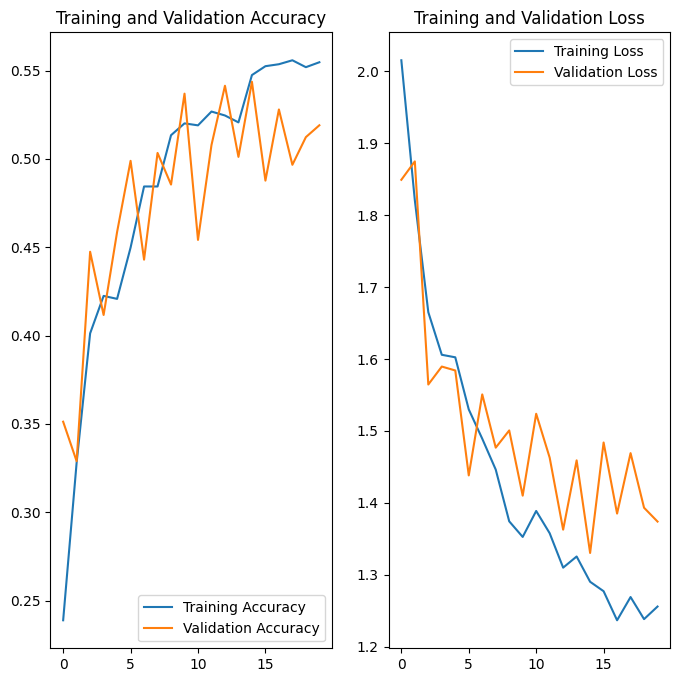

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings
- There is not much improvements in the accuracy of the base model, but we definitely see the overfitting issue fading away after augmentation.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
1,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
2,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
3,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
4,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
...,...,...
2234,CNN_assignment\Train\vascular lesion\ISIC_0033...,vascular lesion
2235,CNN_assignment\Train\vascular lesion\ISIC_0033...,vascular lesion
2236,CNN_assignment\Train\vascular lesion\ISIC_0033...,vascular lesion
2237,CNN_assignment\Train\vascular lesion\ISIC_0034...,vascular lesion


<BarContainer object of 9 artists>

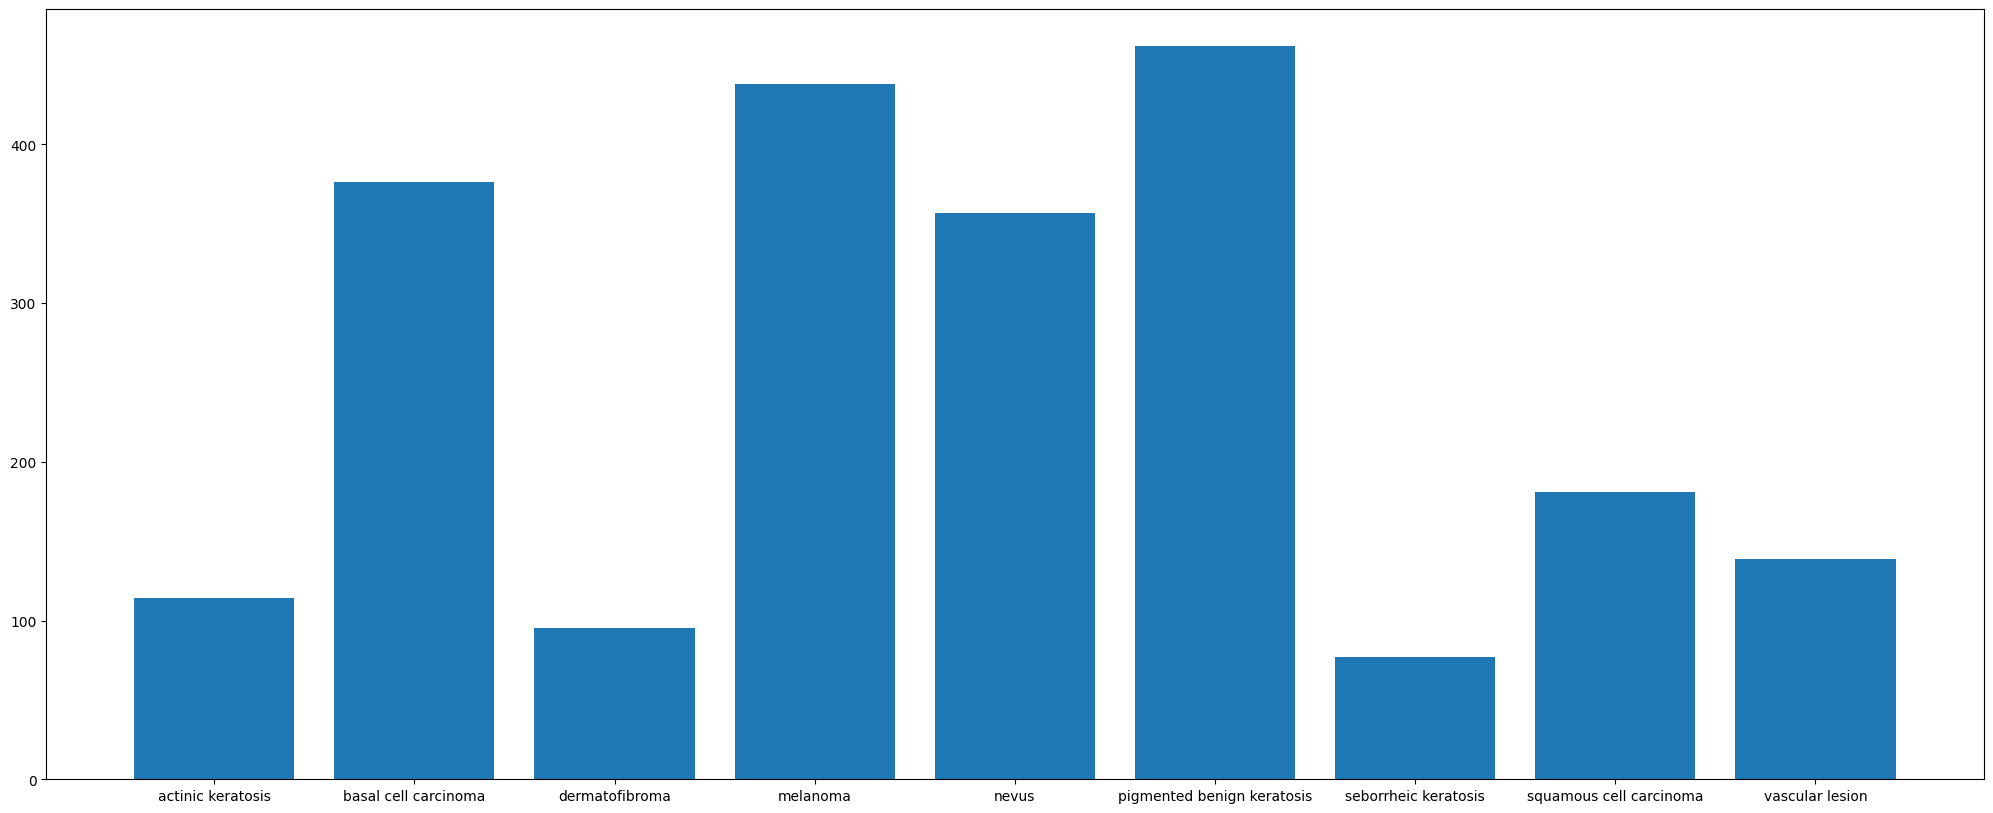

In [24]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

## Findings
#### - Which class has the least number of samples?
Seborrheic Keratosis has the least number of samples.
#### - Which class has the highest number of samples?
Pigmented Benign Keratosis has the highest distribution of data.
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented Benign Keratosis and Melanoma are the two top classes which dominate.

#### Rectify the class imbalance
#### **Context:** Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19C473ACAC0>: 100%|█| 500/500 [00:15<00:00, 31.39 Samples/


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x19C4B57B850>: 100%|█| 500/500 [00:17<00:


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19D534122C0>: 100%|█| 500/500 [00:17<00:00, 29.28 Samples/


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x19D53A1EBC0>: 100%|█| 500/500 [01:10<00:00,  7.06 Samples


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x19D533E39A0>: 100%|█| 500/500 [00:52<0


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x19D590A7940>: 100%|█| 500/500 [00:13<00:


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x19CCC1D5060>: 100%|█| 500/500 [00:24<00:00, 20.18 Samples


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x19CCC211AE0>: 100%|█| 500/500 [00:11<00:


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19CCC1D5900>: 100%|█| 500/500 [00:11<00:00, 42.12 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_01defe5c-3d92-41af-a958-b59e2905d954.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_181f3c82-70a3-487d-83e4-8b1d7460309f.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_25f37e7c-039c-4c60-92cb-bf4699040612.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_598f777d-ec07-4b71-ae58-a098fbc99132.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7148c339-a820-442b-ba3f-8926074c27b1.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a1bcd7fc-c827-4afc-9c99-b8f1bfd0d454.jpg',
 'CNN_assignment\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a39f4121-f0fd-40a8-b1ef-7c39757e7614.jpg',
 'CNN_assignment\\Train\\ac

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)
new_df

,Path,Label
0,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
1,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
2,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
3,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
4,CNN_assignment\Train\actinic keratosis\ISIC_00...,actinic keratosis
...,...,...
6734,CNN_assignment\Train\vascular lesion\output\va...,vascular lesion
6735,CNN_assignment\Train\vascular lesion\output\va...,vascular lesion
6736,CNN_assignment\Train\vascular lesion\output\va...,vascular lesion
6737,CNN_assignment\Train\vascular lesion\output\va...,vascular lesion


In [31]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [33]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    label_mode='categorical'
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    label_mode='categorical'
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [62]:
num_classes = 9

model = Sequential([layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

#First Convulation layer
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Dense Layer with softmax activation function.
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           1,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model (Choose optimizer and loss function appropriately)

In [64]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


#### Training your model

In [66]:
epochs = 50

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[learning_rate_reduction, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 104s 614ms/step - accuracy: 0.5981 - loss: 1.0926 - val_accuracy: 0.6333 - val_loss: 1.0584 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 97s 570ms/step - accuracy: 0.6095 - loss: 1.0166 - val_accuracy: 0.6340 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 147s 865ms/step - accuracy: 0.6434 - loss: 0.9812 - val_accuracy: 0.6748 - val_loss: 0.9373 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 122s 713ms/step - accuracy: 0.6815 - loss: 0.8655 - val_accuracy: 0.7060 - val_loss: 0.8724 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 105s 619ms/step - accuracy: 0.6995 - loss: 0.7935 - val_accuracy: 0.7268 - val_loss: 0.7907 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 513ms/step - accuracy: 0.7338 - loss: 0.7267 - val_accuracy: 0.7223 - val_loss: 0.7758 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 108s 638ms/step - accuracy

#### Visualize the model results

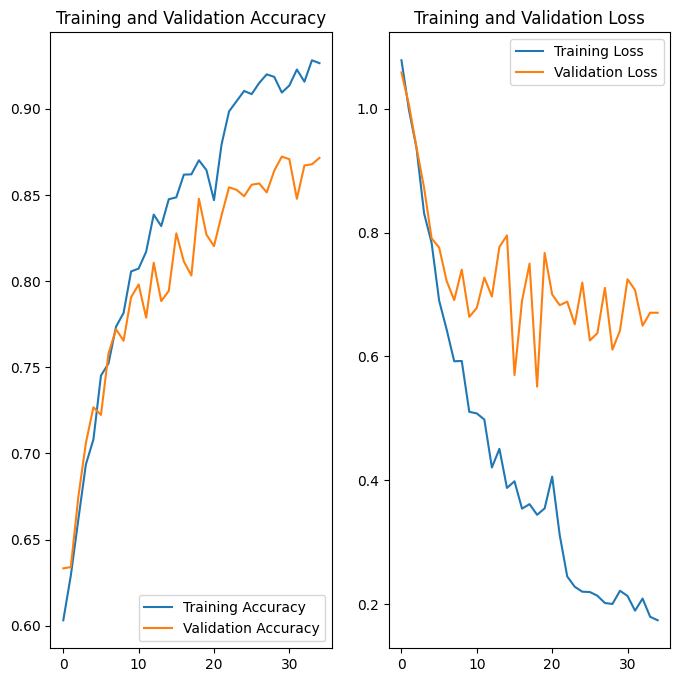

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyzing the results


The overfitting is reduced and the accuracy is above 85% which is pretty good. Although we see the validation loss is pretty high. And the predictions might not be accurate. Lets go ahead to predictions.

In [78]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,  # Set to True if you want to shuffle the dataset
)

Found 118 files belonging to 9 classes.


In [79]:
predictions = model.predict(dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step


In [80]:
print(predictions)

[[6.0041493e-04 2.5302617e-04 3.1196217e-07 ... 1.1491349e-02
  5.7291227e-06 5.4970365e-06]
 [8.5637472e-31 8.9401886e-30 6.8358380e-27 ... 6.6204788e-09
  1.6162922e-29 1.7238657e-28]
 [7.7841617e-02 1.0270065e-07 2.6926557e-05 ... 1.4682652e-30
  4.0419135e-10 1.8514068e-12]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [2.5429110e-05 9.9082762e-01 2.0195236e-07 ... 3.2150799e-11
  3.5633643e-09 2.2028604e-07]
 [0.0000000e+00 7.3330796e-26 9.3853330e-36 ... 0.0000000e+00
  6.3108626e-33 1.0000000e+00]]


In [83]:
for images, labels in dataset:
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    for i in range(len(images)):
        print("Image:", class_names[labels[i]], " | Predicted Class:", class_names[predicted_classes[i]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Image: actinic keratosis  | Predicted Class: melanoma
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: pigmented benign keratosis
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: actinic keratosis  | Predicted Class: nevus
Image: basal cell carcinoma  | Predicted Class: basal cell carcinoma
Image: basal cell carcinoma  | Predicted Class: derm